In [1]:
import time
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from py2neo import Graph, Node, Relationship
%matplotlib inline



In [2]:
def query_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df

In [3]:
graph = Graph( "bolt://matlaber10.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


#### Community focus

In [4]:
query = """call apoc.export.csv.query("

// denominator

MATCH (u:NatureAuthor)

MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WITH e.strength AS weight, u, COUNT(b) AS k_u

WITH u, toFloat(sum(weight*k_u))/sum(k_u) AS den



// intracommunity focus

OPTIONAL MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WHERE last(b.louvain) = last(u.louvain)

WITH den, u, COUNT(b) AS k_intra_u, CASE WHEN e IS NULL THEN 0 ELSE e.strength END AS weight

WITH den, u, CASE WHEN sum(k_intra_u)=0 THEN 0 ELSE toFloat(sum(weight*k_intra_u))/sum(k_intra_u) END AS num

WITH den, u, CASE WHEN den=0 THEN 0 ELSE num/den END AS NatureIntraCommunityFocus

WITH den, u, NatureIntraCommunityFocus



// intercommunity focus

OPTIONAL MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WHERE last(b.louvain) <> last(u.louvain)

WITH den, u, NatureIntraCommunityFocus, COUNT(b) AS k_inter_u, CASE WHEN e IS NULL THEN 0 ELSE e.strength END AS weight

WITH den, u, NatureIntraCommunityFocus, CASE WHEN sum(k_inter_u)=0 THEN 0 ELSE toFloat(sum(weight*k_inter_u))/sum(k_inter_u) END AS num

WITH u, NatureIntraCommunityFocus, CASE WHEN den=0 THEN 0 ELSE num/den END AS NatureInterCommunityFocus



RETURN u.name, NatureIntraCommunityFocus, NatureInterCommunityFocus

","/import/result/author_focus.csv",{})"""

df_community_focus = query_to_df(query, graph)

Starting query... Done (11.96 minutes).


#### Professor connections

In [ ]:
#Augment nodes with pct_last_author
query = """call apoc.periodic.iterate(
"MATCH (a:Top42Author) RETURN a",
"MATCH (a)-[r:AUTHORED]->(:Quanta)
WITH a, toFloat(SUM(CASE WHEN r.is_last_author THEN 1 ELSE 0 END))/COUNT(r) as pct_last_author
SET a.pct_last_author = pct_last_author", {batchSize:100, parallel:true})
"""

df_last_author = query_to_df(query, graph)

Starting query... 

In [4]:
query = """
    MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
    WITH a, COUNT(q) AS num_pubs
    MATCH (a)-[:AUTHORED]-(q:Quanta)-[:AUTHORED]-(b:NatureAuthor)
    WHERE b.pct_last_author > .5
    WITH a, num_pubs, COUNT(distinct q) as num_coauthored_with_prof
    RETURN a.name AS name, num_coauthored_with_prof as num_pubs_with_prof, num_pubs, toFloat(num_coauthored_with_prof)/num_pubs AS ratio_pubs_with_prof
"""
profs_per_paper = query_to_df(query, graph)

In [5]:
profs_per_paper

,name,num_pubs,num_pubs_with_prof,ratio_pubs_with_prof
0,Changlu Liu,103,14,0.135922
1,Claire M. Wagner,37,1,0.027027
2,Robin M. Murray,607,39,0.064250
3,Sarah Nichol,7,3,0.428571
4,Francois Roddier,262,19,0.072519
5,K. Egberts,198,151,0.762626
6,Rupa Sridharan,22,3,0.136364
7,L. Bernstein,115,18,0.156522
8,Patrick K. Kimes,8,7,0.875000
9,Corey B. Puryear,16,2,0.125000


In [6]:
profs_per_paper.to_csv('C:\\Users\\Brend\\Downloads\\paper.csv', index = False, encoding = "UTF-8")

In [ ]:
#Ratio of prof-prof connected papers
#WORKING
query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
WITH a, COUNT(q) AS num_pubs
MATCH (a)-[r:COAUTHOR]-(b:NatureAuthor)
WHERE b.pct_last_author > .5
WITH a, num_pubs, SUM(r.strength42) as num_coauthored_with_prof
RETURN a.name AS name, num_coauthored_with_prof as prof_connections, num_pubs, toFloat(num_coauthored_with_prof)/num_pubs AS coauthor_profs_ratio"""

df_coauthor_profs_ratio = query_to_df(query, graph)

In [ ]:
df_coauthor_papers_ratio.sort_values('coauthor_profs_ratio', ascending=False).tail(10)

In [10]:
df_coauthor_profs_ratio.to_csv('C:\\Users\\Brend\\Downloads\\coauthor_profs_ratio.csv', index = False, encoding = "UTF-8")

#### Cross-cluster edges

In [5]:
#Ratio of cross-cluster and intra-cluster edges to total edges
#WORKING
query = """
MATCH (u:NatureAuthor)
MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)
WITH u, COUNT(b) AS k_u
WITH u, k_u AS den

// intracommunity edges
OPTIONAL MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)
WHERE last(b.louvain) = last(u.louvain)
WITH den, u, COUNT(b) AS k_intra_u
WITH den, u, k_intra_u AS IntraClusterConns, CASE WHEN den=0 THEN 0 ELSE toFloat(k_intra_u)/den END AS IntraClusterRatio
WITH den, u, IntraClusterRatio, IntraClusterConns, 1.0 - IntraClusterRatio AS InterClusterRatio

RETURN u.name AS name, IntraClusterRatio, InterClusterRatio, den AS TotalConns, IntraClusterConns, den - IntraClusterConns AS InterClusterConns
"""

df_clusters = query_to_df(query, graph)

Starting query... Done (6.46 minutes).


In [7]:
df_clusters.head(15)

,InterClusterConns,InterClusterRatio,IntraClusterConns,IntraClusterRatio,TotalConns,name
0,0,0.000000,1,1.000000,1,Carlisle Hj
1,3,0.750000,1,0.250000,4,Toshikazu Oshiki
2,0,0.000000,2,1.000000,2,Muriel M. Lippman
3,111,0.874016,16,0.125984,127,Calliope A. Dendrou
4,67,0.455782,80,0.544218,147,F. Ménard
5,30,0.222222,105,0.777778,135,David Zhao
6,3,0.500000,3,0.500000,6,B. Latte
7,2,0.666667,1,0.333333,3,Paquin
8,28,0.094276,269,0.905724,297,Ines Müller
9,0,0.000000,2,1.000000,2,Michael L. Dean


In [8]:
df_clusters.to_csv('C:\\Users\\Brend\\Downloads\\clusters.csv', index = False, encoding = "UTF-8")

#### Preparing metrics csv

In [48]:
df_clusters = pd.read_csv('C:\\Users\\Brend\\Downloads\\clusters.csv', index_col = 'name', encoding = "UTF-8")

In [50]:
df_papers = pd.read_csv('C:\\Users\\Brend\\Downloads\\papers.csv', index_col = 'name', encoding = "UTF-8")

In [53]:
df_profs = pd.read_csv('C:\\Users\\Brend\\Downloads\\profs.csv', index_col = 'name', encoding = 'UTF-8')

In [56]:
df_profs_papers = df_profs.join(df_papers[['num_pubs_with_prof', 'ratio_pubs_with_prof']], how = 'outer')

In [57]:
df_all = df_profs_papers.join(df_clusters, how = 'outer')

In [59]:
df_author_focus = pd.read_csv('C:\\Users\\Brend\\Downloads\\author_focus.csv', index_col = 'name', encoding = 'UTF-8')

In [61]:
df_all = df_all.join(df_author_focus, how = 'outer')

In [63]:
df_all.to_csv('C:\\Users\\Brend\\Downloads\\metrics.csv', encoding = "UTF-8")

#### All metrics

In [4]:
df_metrics = pd.read_csv('C:\\Users\\Brend\\Downloads\\metrics.csv', index_col = 'name', encoding = "UTF-8")

In [5]:
import random
indices = []
for i in range(10):
    indices.append(random.randrange(0, df_metrics.shape[0]))
df_metrics.iloc[indices]

,profs_per_pub,num_pubs,profs,pubs_with_profs,ratio_pubs_with_prof,InterClusterConns,InterClusterRatio,IntraClusterConns,IntraClusterRatio,TotalConns,IntraCommunityFocus,InterCommunityFocus
name,,,,,,,,,,,,
Trevor J. Wardill,0.037037,27.0,1.0,16.0,0.592593,13.0,0.619048,8.0,0.380952,21.0,0.562500,1.269231
van J Jeroen Tilborg,0.142857,7.0,1.0,7.0,1.000000,0.0,0.000000,8.0,1.000000,8.0,0.000000,0.000000
Jason O’Brien,NaN,NaN,NaN,NaN,NaN,2.0,0.083333,22.0,0.916667,24.0,0.000000,0.000000
David H. Bromwich,0.012780,313.0,4.0,26.0,0.083067,47.0,0.286585,117.0,0.713415,164.0,0.883269,1.290586
Martha Kane Savage,0.055215,163.0,9.0,22.0,0.134969,11.0,0.120879,80.0,0.879121,91.0,0.702574,3.163102
Han-Tzong Su,0.016393,61.0,1.0,21.0,0.344262,3.0,0.300000,7.0,0.700000,10.0,0.476190,2.222222
Alfred Arnason,0.034483,58.0,2.0,8.0,0.137931,18.0,1.000000,0.0,0.000000,18.0,0.000000,1.000000
Robert Walton,0.005780,173.0,1.0,13.0,0.075145,20.0,0.869565,3.0,0.130435,23.0,0.239583,1.114062
Catherine M. F. Lohmann,0.214286,28.0,6.0,26.0,0.928571,0.0,0.000000,4.0,1.000000,4.0,1.000000,0.000000


#### Impact

In [ ]:
#    CALL algo.pageRank(
#     'MATCH (p:Quanta {venue:"Nature"}) RETURN id(p) as id',
#     'MATCH (p1:Quanta {venue:"Nature"})-[:CITES]->(p2:Quanta {venue:"Nature"}) RETURN id(p1) as source, id(p2) as target',
#     {graph:'cypher', iterations:35, write:true, writeProperty:"npr"});

In [4]:
query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
WHERE q.venue = 'Nature'
WITH a, COUNT(q) AS num_pubs, SUM(q.npr) AS tot_rank, MIN(q.npr) AS min_rank, MAX(q.npr) AS max_rank, percentileCont(q.npr, 0.5) AS median_rank 
RETURN a.name AS name, num_pubs, toFloat(tot_rank)/num_pubs AS avg_NPR, min_rank AS min_NPR, max_rank AS max_NPR, median_rank AS median_NPR
"""

df_npr = query_to_df(query, graph)

Starting query... Done (0.41 minutes).


In [5]:
df_npr.head(2)

,avg_NPR,max_NPR,median_NPR,min_NPR,name,num_pubs
0,0.356125,0.356125,0.356125,0.356125,Bruce E. White,1
1,0.150000,0.150000,0.150000,0.150000,Pieter W. Kat,1


In [6]:
query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
WHERE q.venue = 'Nature'
WITH a, COUNT(q) AS num_pubs, SUM(q.nar) AS tot_rank, MIN(q.nar) AS min_rank, MAX(q.nar) AS max_rank, percentileCont(q.nar, 0.5) AS median_rank 
RETURN a.name AS name, num_pubs, toFloat(tot_rank)/num_pubs AS avg_NAR, min_rank AS min_NAR, max_rank AS max_NAR, median_rank AS median_NAR
"""

df_nar = query_to_df(query, graph)

Starting query... Done (0.34 minutes).


In [7]:
df_nar.head(2)

,avg_NAR,max_NAR,median_NAR,min_NAR,name,num_pubs
0,0.28266,0.28266,0.28266,0.28266,Bruce E. White,1
1,0.15000,0.15000,0.15000,0.15000,Pieter W. Kat,1


In [8]:
df_npr.to_csv('C:\\Users\\Brend\\Downloads\\npr.csv', index = False, encoding = "UTF-8")
df_nar.to_csv('C:\\Users\\Brend\\Downloads\\nar.csv', index = False, encoding = "UTF-8")

In [13]:
query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
WHERE q.venue = 'Nature'
WITH a, COUNT(q) AS num_pubs, SUM(q.pageRank_2018) AS tot_rank, MIN(q.pageRank_2018) AS min_rank, MAX(q.pageRank_2018) AS max_rank, percentileCont(q.pageRank_2018, 0.5) AS median_rank 
RETURN a.name AS name, num_pubs, toFloat(tot_rank)/num_pubs AS avg_PR, min_rank AS min_PR, max_rank AS max_PR, median_rank AS median_PR
"""

df_pr = query_to_df(query, graph)

Starting query... Done (0.38 minutes).


In [14]:
df_pr.head(2)

,avg_PR,max_PR,median_PR,min_PR,name,num_pubs
0,2.297610,2.297610,2.297610,2.297610,Bruce E. White,1
1,0.345645,0.345645,0.345645,0.345645,Pieter W. Kat,1


In [15]:
query = """
MATCH (a:NatureAuthor)-[:AUTHORED]->(q:Quanta)
WHERE q.venue = 'Nature'
WITH a, COUNT(q) AS num_pubs, SUM(q.articleRank2018) AS tot_rank, MIN(q.articleRank2018) AS min_rank, MAX(q.articleRank2018) AS max_rank, percentileCont(q.articleRank2018, 0.5) AS median_rank 
RETURN a.name AS name, num_pubs, toFloat(tot_rank)/num_pubs AS avg_AR, min_rank AS min_AR, max_rank AS max_AR, median_rank AS median_AR
"""

df_ar = query_to_df(query, graph)

Starting query... Done (0.35 minutes).


In [16]:
df_ar.head(2)

,avg_AR,max_AR,median_AR,min_AR,name,num_pubs
0,1.330131,1.330131,1.330131,1.330131,Bruce E. White,1
1,0.275562,0.275562,0.275562,0.275562,Pieter W. Kat,1


In [17]:
df_pr.to_csv('C:\\Users\\Brend\\Downloads\\pr.csv', index = False, encoding = "UTF-8")
df_ar.to_csv('C:\\Users\\Brend\\Downloads\\ar.csv', index = False, encoding = "UTF-8")

In [20]:
df_npr = pd.read_csv('C:\\Users\\Brend\\Downloads\\npr.csv', index_col = 'name', encoding = "UTF-8")
df_nar = pd.read_csv('C:\\Users\\Brend\\Downloads\\nar.csv', index_col = 'name', encoding = "UTF-8")
df_pr = pd.read_csv('C:\\Users\\Brend\\Downloads\\pr.csv', index_col = 'name', encoding = "UTF-8")
df_ar = pd.read_csv('C:\\Users\\Brend\\Downloads\\ar.csv', index_col = 'name', encoding = "UTF-8")

In [21]:
df_npr = df_npr[[col for col in df_npr.columns if col != 'num_pubs']]
df_nar = df_nar[[col for col in df_nar.columns if col != 'num_pubs']]
df_pr = df_pr[[col for col in df_pr.columns if col != 'num_pubs']]
df_ar = df_ar[[col for col in df_ar.columns if col != 'num_pubs']]

In [22]:
df_imp = df_npr.join(df_nar, how = 'outer')
df_imp = df_imp.join(df_pr, how = 'outer')
df_imp = df_imp.join(df_ar, how = 'outer')

In [23]:
df_imp.to_csv('C:\\Users\\Brend\\Downloads\\impact.csv', encoding = "UTF-8")

#### Collaboration vs Impact

In [24]:
df_collab = pd.read_csv('C:\\Users\\Brend\\Downloads\\metrics.csv', index_col = 'name', encoding = "UTF-8")
df_impact = pd.read_csv('C:\\Users\\Brend\\Downloads\\impact.csv', index_col = 'name', encoding = "UTF-8")
df_all = df_collab.join(df_impact, how = 'outer')

In [25]:
df_all.to_csv('C:\\Users\\Brend\\Downloads\\correlation.csv', encoding = "UTF-8")

In [31]:
df_all[df_all.index == 'Eric S. Lander']

,profs_per_pub,num_pubs,profs,pubs_with_profs,ratio_pubs_with_prof,InterClusterConns,InterClusterRatio,IntraClusterConns,IntraClusterRatio,TotalConns,...,median_NAR,min_NAR,avg_PR,max_PR,median_PR,min_PR,avg_AR,max_AR,median_AR,min_AR
name,,,,,,,,,,,,,,,,,,,,,
Eric S. Lander,0.743802,726.0,540.0,270.0,0.371901,3647.0,0.681937,1701.0,0.318063,5348.0,...,0.475278,0.15,10.361763,179.527591,3.731212,0.15,6.344966,100.363912,2.630555,0.15


In [49]:
df_plot = df_all[['profs_per_pub', 'median_AR']]
df_plot = df_plot[df_plot['median_AR'] < 50]
df_plot = df_plot[df_plot['median_AR'] > .16]
df_plot = df_plot[df_plot['profs_per_pub'] > .1]

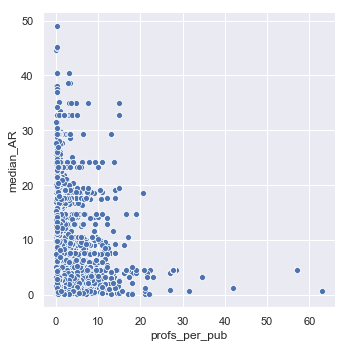

In [50]:
import seaborn as sns
sns.set()
sns.relplot(x="profs_per_pub", y="median_AR",  
            data=df_plot);